In [1]:
import pyreadr
from shapely.geometry import MultiPoint, Point, LineString
import pandas as pd
import geopandas as gpd
import numpy as np
from scipy import stats
import seaborn as sns

from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

# tip_amount

## Load relevant data

Import any relevant data. Explore the structure of the datasets in order to draft a strategy for achieving the lab goal. You can add more code chunks to break down the analysis in smaller steps.


In [2]:
result = pyreadr.read_r('./data/NYC_TLC_trip_data_extract_2016-03-21.rds')
result2 = pyreadr.read_r('./data/NYC_TLC_trip_data_extract_2016-03-28.rds')

df = result[None]
df2 = result2[None]

In [3]:
df['pickup_longitude'].value_counts()

pickup_longitude
 0.000000     5350
-73.982201     151
-73.982208     148
-73.982140     148
-73.982094     143
              ... 
-73.874100       1
-73.891541       1
-74.270966       1
-73.891312       1
-74.204445       1
Name: count, Length: 16446, dtype: int64

## Prepare data for analysis

Make relevant data conversions, filtering or aggregation. You can add more code chunks to break down the analysis in smaller steps.

In [4]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.pickup_longitude, df.pickup_latitude))

pickup_gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.pickup_longitude, df.pickup_latitude), crs='EPSG:4326').to_crs('EPSG:32618')
dropoff_gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.dropoff_longitude, df.dropoff_latitude), crs='EPSG:4326').to_crs('EPSG:32618')

gdf['dropoff'] = [Point(x, y) for x, y in zip(df.dropoff_longitude, df.dropoff_latitude)]
gdf['multi'] = [MultiPoint([x, y]) for x, y in zip(gdf.geometry, gdf.dropoff)]
gdf.rename(columns={'geometry': 'pickup'}, inplace=True)
gdf['line'] =  [(LineString([[a.x, a.y],[b.x, b.y]])) for (a,b) in zip(gdf['pickup'], gdf['dropoff'])]

cleaned_gdf = gdf.set_geometry('line')
cleaned_gdf.set_crs('EPSG:4326', inplace=True)
cleaned_gdf.to_crs('EPSG:32618', inplace=True)

gdf = cleaned_gdf

In [5]:
gdf['long']=(pickup_gdf.distance(dropoff_gdf)/1000)

In [6]:
gdf = gdf[gdf.long!=0]

In [7]:
gdf = gdf[gdf.long<783]

In [8]:
gdf['line'][:50].explore()

In [9]:
gdf2 = gpd.GeoDataFrame(df2, geometry=gpd.points_from_xy(df2.pickup_longitude, df2.pickup_latitude))

pickup_gdf2 = gpd.GeoDataFrame(df2, geometry=gpd.points_from_xy(df2.pickup_longitude, df2.pickup_latitude), crs='EPSG:4326').to_crs('EPSG:32618')
dropoff_gdf2 = gpd.GeoDataFrame(df2, geometry=gpd.points_from_xy(df2.dropoff_longitude, df2.dropoff_latitude), crs='EPSG:4326').to_crs('EPSG:32618')

gdf2['dropoff'] = [Point(x, y) for x, y in zip(df2.dropoff_longitude, df2.dropoff_latitude)]
gdf2['multi'] = [MultiPoint([x, y]) for x, y in zip(gdf2.geometry, gdf2.dropoff)]
gdf2.rename(columns={'geometry': 'pickup'}, inplace=True)
gdf2['line'] =  [(LineString([[a.x, a.y],[b.x, b.y]])) for (a,b) in zip(gdf2['pickup'], gdf2['dropoff'])]

cleaned_gdf2 = gdf2.set_geometry('line')
cleaned_gdf2.set_crs('EPSG:4326', inplace=True)
cleaned_gdf2.to_crs('EPSG:32618', inplace=True)

gdf_test = cleaned_gdf2

## Feature engineering

Add one or more variables to your dataset by combining existing variables
or extracting something from some variable.

In [10]:
gdf['duration']=(gdf.tpep_dropoff_datetime-gdf.tpep_pickup_datetime).astype('timedelta64[s]')

In [11]:
gdf['duration']=gdf.duration/pd.offsets.Minute(1)

In [12]:
gdf['pick_m']=gdf.tpep_pickup_datetime.dt.minute
gdf['pick_h']=gdf.tpep_pickup_datetime.dt.hour
gdf['drop_m']=gdf.tpep_dropoff_datetime.dt.minute
gdf['drop_h']=gdf.tpep_dropoff_datetime.dt.hour

In [ ]:
gdf['store_and_fwd_flag'].loc[gdf['store_and_fwd_flag'] == 'N'] = 0
gdf['store_and_fwd_flag'].loc[gdf['store_and_fwd_flag'] == 'Y'] = 1
gdf = gdf[gdf['RatecodeID']<5]
gdf['extra'].loc[gdf['extra'] > 0] = 1
gdf['extra'].loc[gdf['extra'] < 0] = 0

data = gdf.drop(columns=['Day', 'Hour', 'mta_tax', 'improvement_surcharge', 'pickup', 'dropoff', 'multi', 'line', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'tpep_dropoff_datetime', 'tpep_pickup_datetime'])

In [14]:
gdf_test['long']=(pickup_gdf2.distance(dropoff_gdf2)/1000)

In [15]:
gdf_test = gdf_test[gdf_test.long!=0]

In [16]:
gdf_test = gdf_test[gdf_test.long<783]

In [17]:
gdf_test['duration']=(gdf_test.tpep_dropoff_datetime-gdf_test.tpep_pickup_datetime).astype('timedelta64[s]')

In [18]:
gdf_test['duration']=gdf_test.duration/pd.offsets.Minute(1)

In [19]:
gdf_test['pick_m']=gdf_test.tpep_pickup_datetime.dt.minute
gdf_test['pick_h']=gdf_test.tpep_pickup_datetime.dt.hour
gdf_test['drop_m']=gdf_test.tpep_dropoff_datetime.dt.minute
gdf_test['drop_h']=gdf_test.tpep_dropoff_datetime.dt.hour

In [ ]:
gdf_test['store_and_fwd_flag'].loc[gdf_test['store_and_fwd_flag'] == 'N'] = 0
gdf_test['store_and_fwd_flag'].loc[gdf_test['store_and_fwd_flag'] == 'Y'] = 1
gdf_test = gdf_test[gdf_test['RatecodeID']<5]
gdf_test['extra'].loc[gdf_test['extra'] > 0] = 1
gdf_test['extra'].loc[gdf_test['extra'] < 0] = 0

test_data = gdf_test.drop(columns=['Day', 'Hour', 'mta_tax', 'improvement_surcharge', 'pickup', 'dropoff', 'multi', 'line', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'tpep_dropoff_datetime', 'tpep_pickup_datetime'])

In [21]:
data.dtypes

VendorID                int32
passenger_count         int32
trip_distance         float64
RatecodeID              int32
store_and_fwd_flag     object
payment_type            int32
fare_amount           float64
extra                 float64
tip_amount            float64
tolls_amount          float64
total_amount          float64
long                  float64
duration              float64
pick_m                  int32
pick_h                  int32
drop_m                  int32
drop_h                  int32
dtype: object

In [22]:
cat_fe = ['VendorID', 'RatecodeID', 'payment_type', 'extra', 'pick_m', 'pick_h', 'drop_m', 'drop_h', 'store_and_fwd_flag']

In [23]:
for cat in cat_fe:
    data[cat] = data[cat].astype('int')
    test_data[cat] = test_data[cat].astype('int')

In [24]:
data['passenger_count'] = data['passenger_count'].astype('float')

In [25]:
test_data['passenger_count'] = test_data['passenger_count'].astype('float')

In [26]:
data_z = data[(np.abs(stats.zscore(data.select_dtypes(include=np.number))) < 3).all(axis=1)]
test_data_z = test_data[(np.abs(stats.zscore(test_data.select_dtypes(include=np.number))) < 3).all(axis=1)]

In [49]:
num_fe = list(data_z.columns.difference(cat_fe, sort=False))

In [28]:
# for num in num_fe:
#     data_z[num].loc[data_z[num] < 0] = 0
#     test_data[num].loc[test_data[num] < 0] = 0

## Exploratory data analysis, correlations

Study the structure and inner intervariable relationships, create correlation
plot, comment on it and choose variables suitable for regression.

In [29]:
data_z.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,payment_type,fare_amount,extra,tip_amount,tolls_amount,total_amount,long,duration,pick_m,pick_h,drop_m,drop_h
count,296609.000000,296609.000000,296609.000000,296609.0,296609.0,296609.000000,296609.000000,296609.000000,296609.000000,296609.000000,296609.000000,296609.000000,296609.000000,296609.000000,296609.000000,296609.000000,296609.000000
mean,1.515638,1.480434,2.200585,1.0,0.0,1.349116,10.201260,0.518986,1.390125,0.000623,12.772277,2.668890,11.143536,29.650095,14.117866,29.715063,14.160326
std,0.499756,1.037038,1.995992,0.0,0.0,0.476692,5.996465,0.499640,1.468573,0.039328,6.831297,2.322689,7.216412,17.328015,5.771312,17.409619,5.831776
min,1.000000,1.000000,0.000000,1.0,0.0,1.000000,-7.500000,0.000000,0.000000,0.000000,-9.300000,0.000423,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.960000,1.0,0.0,1.000000,6.000000,0.000000,0.000000,0.000000,8.160000,1.173570,5.916667,15.000000,9.000000,15.000000,10.000000
50%,2.000000,1.000000,1.560000,1.0,0.0,1.000000,8.500000,1.000000,1.200000,0.000000,10.800000,1.922716,9.500000,30.000000,15.000000,30.000000,15.000000
75%,2.000000,1.000000,2.660000,1.0,0.0,2.000000,12.000000,1.000000,2.080000,0.000000,15.300000,3.303011,14.600000,45.000000,19.000000,45.000000,19.000000
max,2.000000,5.000000,35.720000,1.0,0.0,2.000000,45.000000,1.000000,9.450000,2.540000,56.150000,16.101909,172.250000,59.000000,23.000000,59.000000,23.000000


In [30]:
test_data_z.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,payment_type,fare_amount,extra,tip_amount,tolls_amount,total_amount,long,duration,pick_m,pick_h,drop_m,drop_h
count,305952.000000,305952.000000,305952.000000,305952.0,305952.0,305952.000000,305952.000000,305952.000000,305952.000000,305952.000000,305952.000000,305952.000000,305952.000000,305952.000000,305952.000000,305952.000000,305952.000000
mean,1.523053,1.498264,2.425322,1.0,0.0,1.354108,10.863064,0.502674,1.478806,0.178238,13.686028,2.866999,11.804659,29.642741,13.868404,29.770810,13.884381
std,0.499469,1.050787,2.365431,0.0,0.0,0.478243,6.896395,0.499994,1.667157,0.975958,8.456196,2.589539,7.898283,17.312499,5.834160,17.438043,5.900061
min,1.000000,0.000000,0.000000,1.0,0.0,1.000000,-6.000000,0.000000,0.000000,0.000000,-7.300000,0.000423,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.990000,1.0,0.0,1.000000,6.000000,0.000000,0.000000,0.000000,8.300000,1.186697,6.116667,15.000000,9.000000,15.000000,9.000000
50%,2.000000,1.000000,1.600000,1.0,0.0,1.000000,8.500000,1.000000,1.200000,0.000000,11.160000,1.973954,9.900000,30.000000,14.000000,30.000000,14.000000
75%,2.000000,2.000000,2.810000,1.0,0.0,2.000000,13.000000,1.000000,2.160000,0.000000,15.950000,3.520190,15.483333,45.000000,19.000000,45.000000,19.000000
max,2.000000,5.000000,19.900000,1.0,0.0,2.000000,45.000000,1.000000,9.100000,6.000000,56.340000,16.635058,171.000000,59.000000,23.000000,59.000000,23.000000


In [31]:
data_z.head()

,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,payment_type,fare_amount,extra,tip_amount,tolls_amount,total_amount,long,duration,pick_m,pick_h,drop_m,drop_h
0,2,2.0,1.47,1,0,1,7.5,1,1.76,0.0,10.56,1.800128,7.083333,0,0,7,0
1,2,1.0,1.39,1,0,2,6.5,1,0.00,0.0,7.80,0.767479,6.116667,0,0,6,0
3,2,1.0,2.94,1,0,1,11.0,1,1.23,0.0,13.53,3.369067,10.250000,0,0,10,0
4,2,2.0,4.10,1,0,1,15.5,1,3.36,0.0,20.16,4.522182,15.933333,0,0,16,0
6,2,1.0,12.64,1,0,1,35.5,1,7.36,0.0,44.16,13.893044,23.266667,0,0,23,0


In [32]:
test_data_z.head()

,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,payment_type,fare_amount,extra,tip_amount,tolls_amount,total_amount,long,duration,pick_m,pick_h,drop_m,drop_h
0,1,1.0,0.60,1,0,1,4.5,1,1.00,0.00,6.80,0.922062,3.266667,0,0,3,0
1,1,2.0,9.90,1,0,1,34.5,1,7.15,0.00,42.95,14.196837,33.250000,0,0,33,0
3,2,1.0,1.94,1,0,1,9.0,1,2.06,0.00,12.36,3.075871,8.333333,0,0,8,0
5,1,1.0,8.20,1,0,1,24.0,1,4.00,5.54,34.84,8.634790,16.516667,0,0,16,0
6,1,1.0,1.40,1,0,2,7.0,1,0.00,0.00,8.30,1.582910,6.550000,0,0,6,0


In [33]:
data_z.dtypes

VendorID                int32
passenger_count       float64
trip_distance         float64
RatecodeID              int32
store_and_fwd_flag      int32
payment_type            int32
fare_amount           float64
extra                   int32
tip_amount            float64
tolls_amount          float64
total_amount          float64
long                  float64
duration              float64
pick_m                  int32
pick_h                  int32
drop_m                  int32
drop_h                  int32
dtype: object

In [34]:
test_data.dtypes

VendorID                int32
passenger_count       float64
trip_distance         float64
RatecodeID              int32
store_and_fwd_flag      int32
payment_type            int32
fare_amount           float64
extra                   int32
tip_amount            float64
tolls_amount          float64
total_amount          float64
long                  float64
duration              float64
pick_m                  int32
pick_h                  int32
drop_m                  int32
drop_h                  int32
dtype: object

<Axes: >

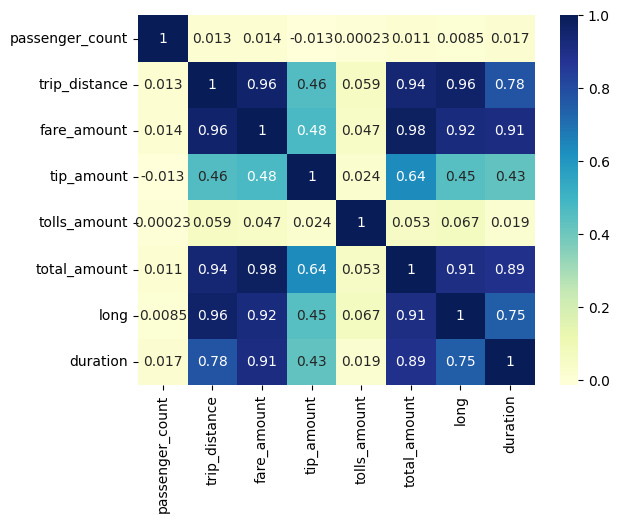

In [35]:
corr = data_z[num_fe].corr()
sns.heatmap(corr, cmap="YlGnBu", annot=True) 

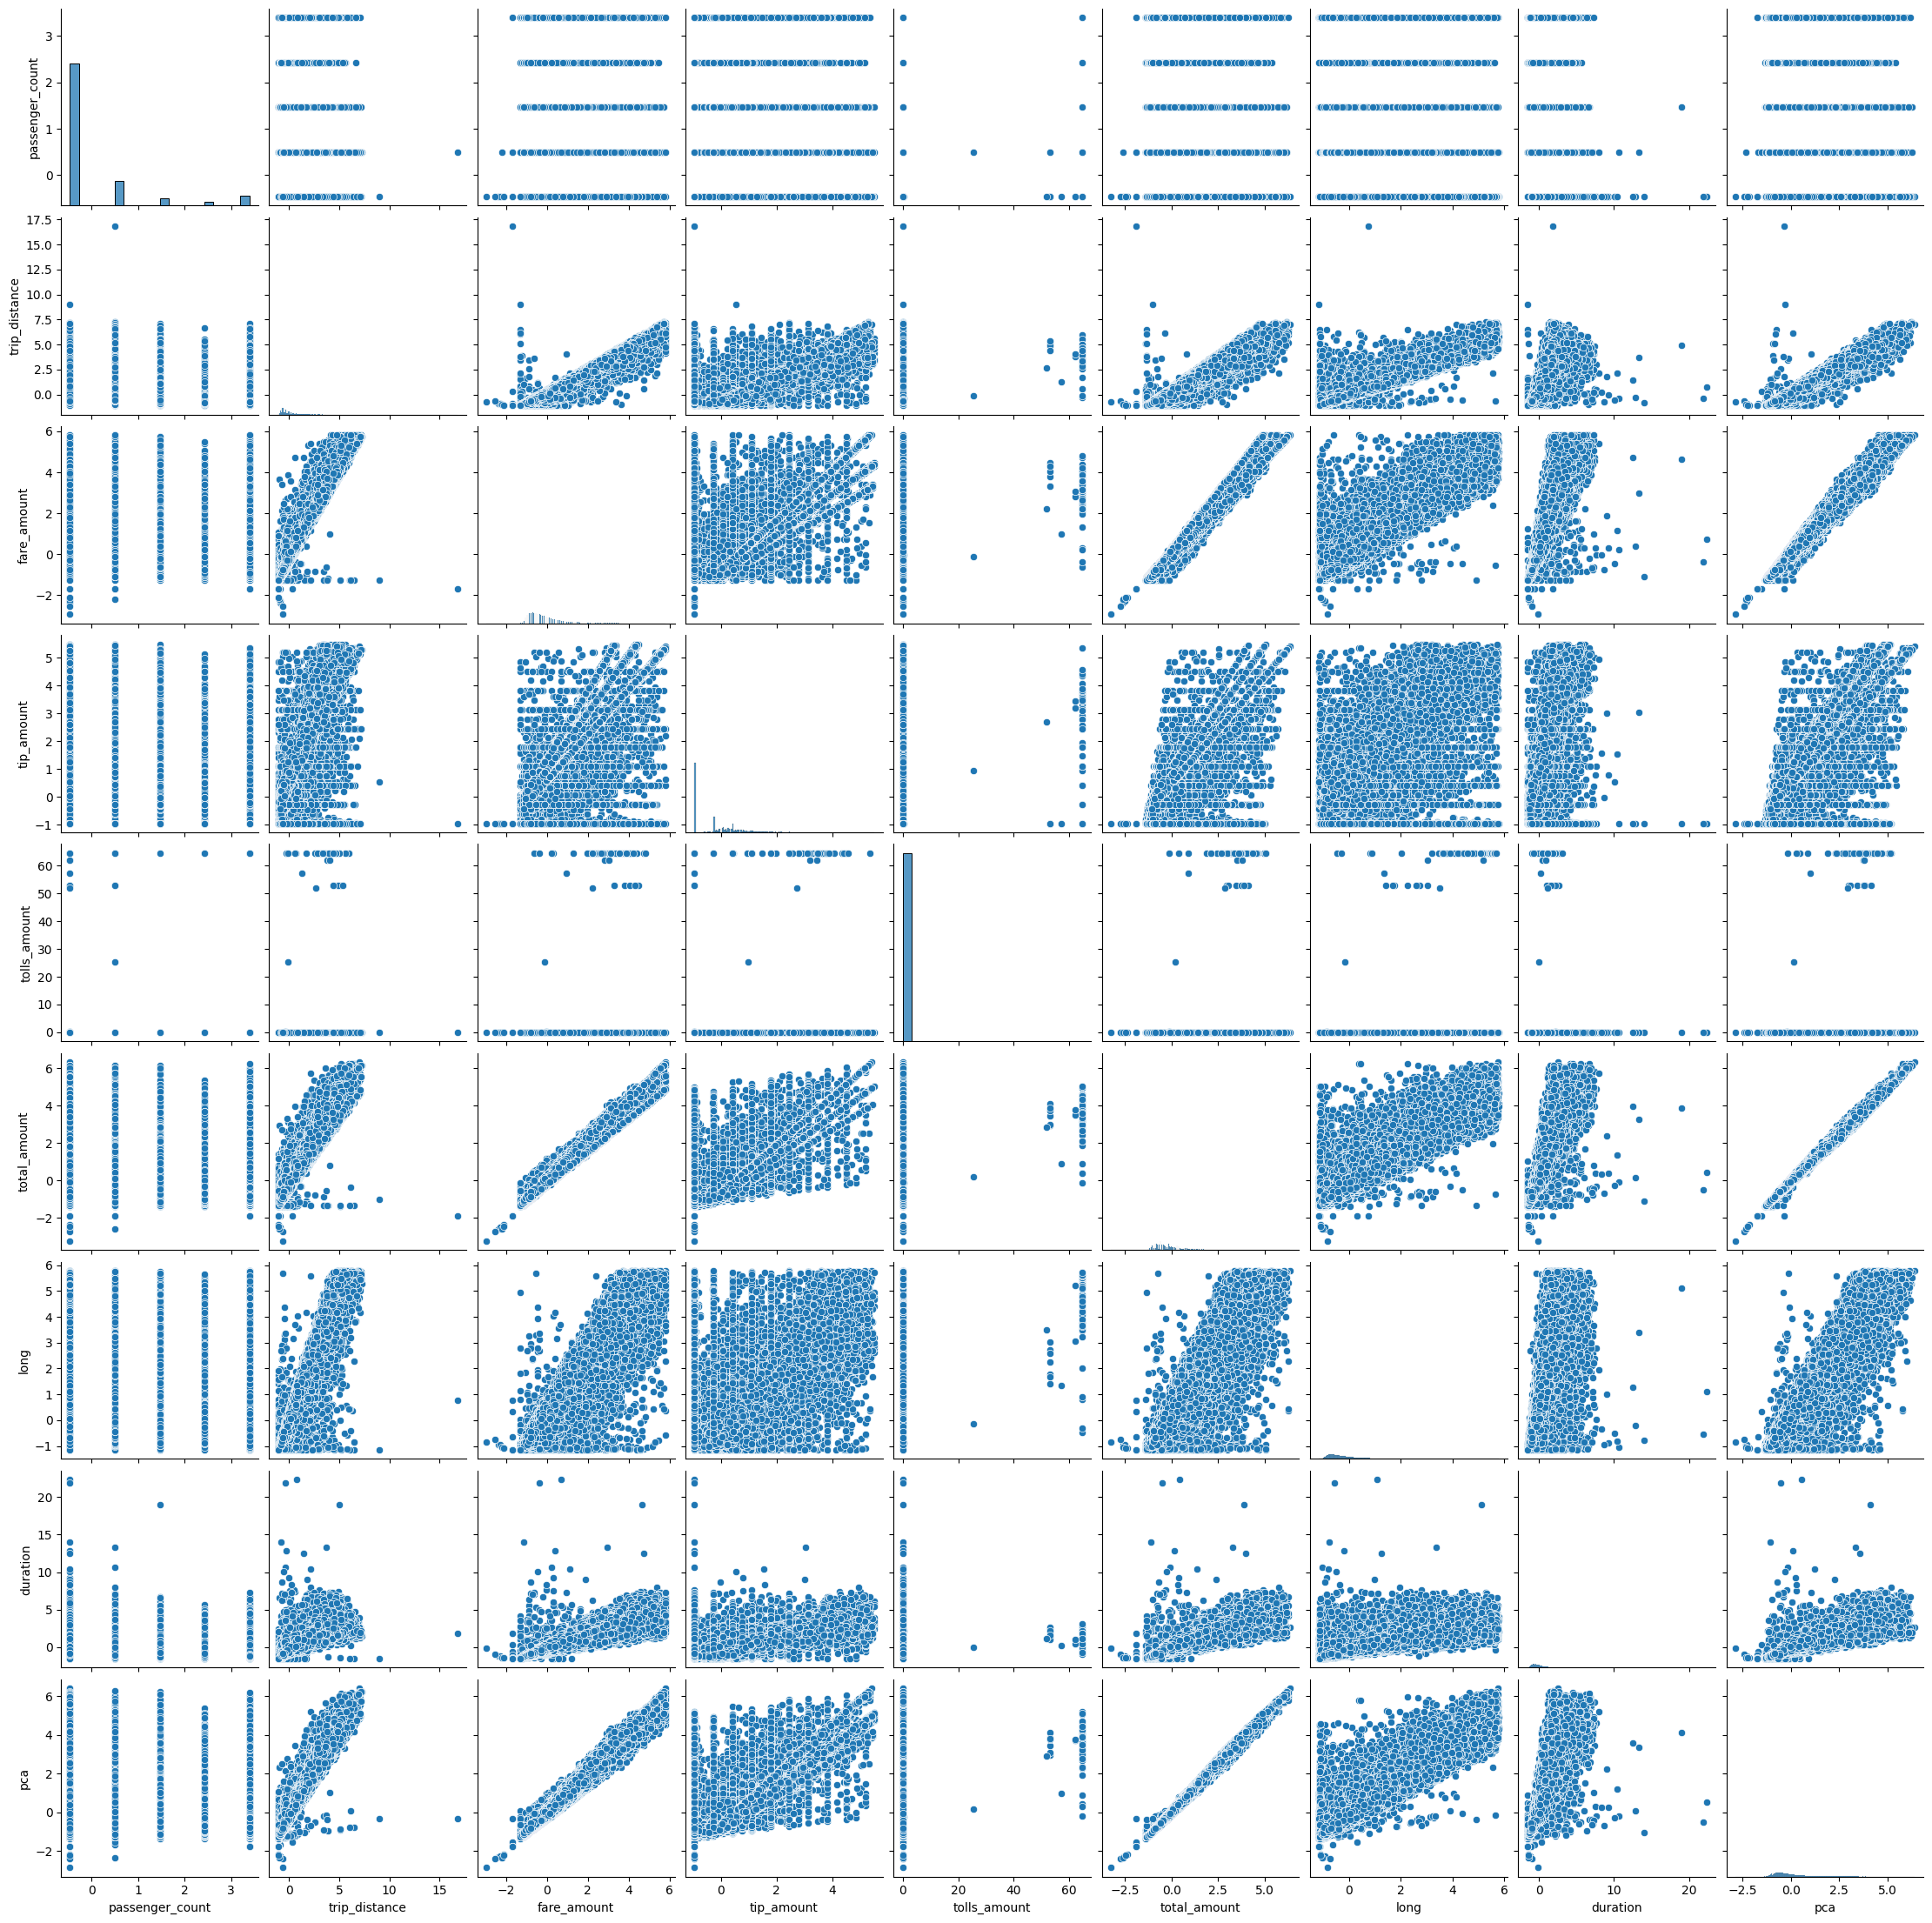

In [92]:
sns.pairplot(data_z[num_fe])

In [ ]:
from sklearn.decomposition import PCA

dim_red = PCA(n_components=1)

data_z['pca'] = dim_red.fit_transform(data_z[['total_amount', 'trip_distance', 'long']])

<Axes: >

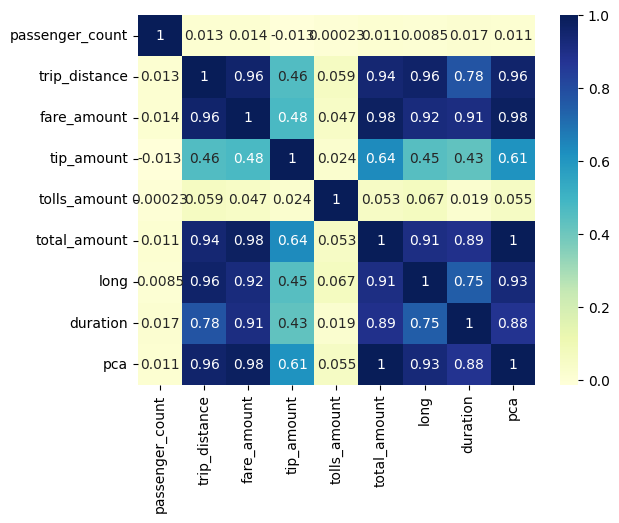

In [51]:
num_fe.append('pca')
corr = data_z[num_fe].corr()
sns.heatmap(corr, cmap="YlGnBu", annot=True)

In [ ]:
test_data_z['pca'] = dim_red.transform(test_data_z[['total_amount', 'trip_distance', 'long']])

In [53]:
data_z[['total_amount', 'trip_distance', 'long', 'pca']]

,total_amount,trip_distance,long,pca
0,10.56,1.47,1.800128,-2.479581
1,7.80,1.39,0.767479,-5.343284
3,13.53,2.94,3.369067,1.093110
4,20.16,4.10,4.522182,7.835122
6,44.16,12.64,13.893044,34.877961
...,...,...,...,...
344316,8.76,1.32,1.180832,-4.356691
344317,6.30,0.70,0.815260,-6.889077
344318,8.84,1.07,1.645411,-4.212112
344320,18.30,3.80,5.228622,6.250666


In [54]:
scaler = StandardScaler()

data_z = pd.DataFrame(scaler.fit_transform(data_z), columns = data_z.columns)
test_data_z = pd.DataFrame(scaler.transform(test_data_z), columns = data_z.columns)

In [55]:
x_train1 = data_z.drop(columns=['total_amount', 'trip_distance', 'long', 'tip_amount'])
y_train1 = data_z['tip_amount']

x_train2 = data_z.drop(columns=['fare_amount', 'tip_amount'])
y_train2 = data_z[['fare_amount', 'tip_amount']]

x_test1 = test_data_z.drop(columns=['total_amount', 'trip_distance', 'long', 'tip_amount'])
y_test1 = test_data_z['tip_amount']

x_test2 = test_data_z.drop(columns=['fare_amount', 'tip_amount'])
y_test2 = test_data_z[['fare_amount', 'tip_amount']]

## Model fitting

Build at least three models, study their performance and make some statistical
tests where needed.

Select the model that performs best.

In [56]:
from sklearn.linear_model import SGDRegressor
params_sgd1 = {'loss': ['huber', 'squared_error'],
                   'penalty': ['l1', 'l2', 'elasticnet'],
                   'max_iter': [800, 1600, 3200, 6400]}

sgd1 = SGDRegressor(early_stopping=True, n_iter_no_change=10)
sgd_grid1 = GridSearchCV(sgd1, params_sgd1, verbose=20, scoring='neg_mean_squared_error')

In [ ]:
sgd_grid1.fit(x_train1, y_train1)

In [58]:
sgd_grid1.best_estimator_

SGDRegressor(early_stopping=True, loss='huber', max_iter=6400,
             n_iter_no_change=10)

In [45]:
# Оказалось слишком дорого, позже разберусь с Kernel Approximation
# from sklearn.svm import SVR
# c_range = np.logspace(-0, 4, 8)
# params_svr1 = [{'kernel': ['rbf'],'C': c_range},
#                {'kernel': ['linear'], 'C': c_range}]
# svr1 = SVR()
# svr_grid1 = GridSearchCV(svr1, params_svr1, verbose=20, scoring='r2')

In [46]:
# svr_grid1.fit(x_train1, y_train1)

In [60]:
from sklearn.linear_model import LinearRegression
lr1 = LinearRegression()
lr1.fit(x_train1, y_train1)

LinearRegression()

In [66]:
from sklearn.neural_network import MLPRegressor
mlpr1 = MLPRegressor(hidden_layer_sizes=(32, 1), activation='logistic', max_iter=10000, batch_size=4096, tol=0.01, learning_rate='adaptive', learning_rate_init=0.01, n_iter_no_change=2, early_stopping=True, verbose=True)
mlpr1.fit(x_train1, y_train1)

Iteration 1, loss = 0.51483454
Validation score: 0.235067
Iteration 2, loss = 0.27766706
Validation score: 0.582697
Iteration 3, loss = 0.17688524
Validation score: 0.708478
Iteration 4, loss = 0.12134210
Validation score: 0.812367
Iteration 5, loss = 0.07691521
Validation score: 0.874696
Iteration 6, loss = 0.05700608
Validation score: 0.899738
Iteration 7, loss = 0.04671296
Validation score: 0.917068
Iteration 8, loss = 0.03911979
Validation score: 0.929702
Iteration 9, loss = 0.03389472
Validation score: 0.938185
Iteration 10, loss = 0.03007873
Validation score: 0.944447
Iteration 11, loss = 0.02717468
Validation score: 0.949310
Validation score did not improve more than tol=0.010000 for 2 consecutive epochs. Stopping.


MLPRegressor(activation='logistic', batch_size=4096, early_stopping=True,
             hidden_layer_sizes=(32, 1), learning_rate='adaptive',
             learning_rate_init=0.01, max_iter=10000, n_iter_no_change=2,
             tol=0.01, verbose=True)

In [68]:
import catboost as cb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [72]:
# train_dataset1 = cb.Pool(data.drop(columns=['total_amount', 'long', 'tip_amount', 'trip_distance']), data['tip_amount'], cat_features=cat_fe) 
# test_dataset1 = cb.Pool(test_data.drop(columns=['total_amount', 'long', 'tip_amount', 'trip_distance']), test_data['tip_amount'], cat_features=cat_fe)

In [79]:
params = {'eval_metric':'R2',
          'early_stopping_rounds': 100,
          'verbose': 200,
          'loss_function':'RMSE',
          'cat_features': cat_fe
         }
cb_reg1 = cb.CatBoostRegressor(**params)
cb_reg1.fit(data.drop(columns=['total_amount', 'long', 'tip_amount', 'trip_distance']), data['tip_amount'], eval_set=(test_data.drop(columns=['total_amount', 'long', 'tip_amount', 'trip_distance']), test_data['tip_amount']), use_best_model=True, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.126959
0:	learn: 0.1649711	test: 0.1755708	best: 0.1755708 (0)	total: 232ms	remaining: 3m 51s
200:	learn: 0.7427897	test: 0.7662649	best: 0.7664325 (167)	total: 32.8s	remaining: 2m 10s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7666463245
bestIteration = 288

Shrink model to first 289 iterations.


In [96]:
import sklearn.metrics as metrics
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [80]:
pred = cb_reg1.predict(test_data.drop(columns=['total_amount', 'long', 'tip_amount', 'trip_distance']))
r2 = r2_score(test_data['tip_amount'], pred)
print('Testing performance')
print('R2: {:.2f}'.format(r2))

Testing performance
R2: 0.77


In [81]:
lr1.score(x_test1, y_test1)

0.9431448835305659

In [82]:
sgd_best1 = sgd_grid1.best_estimator_
sgd_best1.score(x_test1, y_test1)

0.9494486248965879

In [84]:
mlpr1.score(x_test1, y_test1)

0.8428947626370771

# tip_amount / fare_amount

**Repeat the same steps as for tip_amount**

In [85]:
lr2 = LinearRegression()
lr2.fit(x_train2, y_train2)

LinearRegression()

In [86]:
mlpr2 = MLPRegressor(hidden_layer_sizes=(32, 4, 2), activation='logistic', max_iter=10000, batch_size=4096, n_iter_no_change=3, tol=0.01, learning_rate='adaptive', learning_rate_init=0.01, early_stopping=True, verbose=True)
mlpr2.fit(x_train2, y_train2)

Iteration 1, loss = 0.47203173
Validation score: 0.249579
Iteration 2, loss = 0.28014593
Validation score: 0.568091
Iteration 3, loss = 0.18814927
Validation score: 0.664184
Iteration 4, loss = 0.15903007
Validation score: 0.696838
Iteration 5, loss = 0.14868675
Validation score: 0.710929
Iteration 6, loss = 0.14345260
Validation score: 0.719039
Iteration 7, loss = 0.14024884
Validation score: 0.724391
Iteration 8, loss = 0.13795861
Validation score: 0.728299
Iteration 9, loss = 0.13495582
Validation score: 0.740578
Iteration 10, loss = 0.11832438
Validation score: 0.807787
Iteration 11, loss = 0.07214421
Validation score: 0.889779
Iteration 12, loss = 0.04579510
Validation score: 0.924703
Iteration 13, loss = 0.03130136
Validation score: 0.947184
Iteration 14, loss = 0.02363225
Validation score: 0.956323
Iteration 15, loss = 0.02012082
Validation score: 0.960869
Iteration 16, loss = 0.01803995
Validation score: 0.964603
Iteration 17, loss = 0.01655856
Validation score: 0.966843
Valida

MLPRegressor(activation='logistic', batch_size=4096, early_stopping=True,
             hidden_layer_sizes=(32, 4, 2), learning_rate='adaptive',
             learning_rate_init=0.01, max_iter=10000, n_iter_no_change=3,
             tol=0.01, verbose=True)

In [256]:
# train_dataset2 = cb.Pool(data.drop(columns=['fare_amount', 'tip_amount']), data[['fare_amount', 'tip_amount']], cat_features=cat_fe) 
# test_dataset2 = cb.Pool(test_data.drop(columns=['fare_amount', 'tip_amount']), test_data[['fare_amount', 'tip_amount']], cat_features=cat_fe)

In [88]:
params = {'eval_metric':'MultiRMSE',
          'loss_function': 'MultiRMSE', 
          'early_stopping_rounds': 100,
          'verbose': 200,
          'cat_features': cat_fe
         }
cb_reg2 = cb.CatBoostRegressor(**params)
cb_reg2.fit(data.drop(columns=['fare_amount', 'tip_amount']), data[['fare_amount', 'tip_amount']], eval_set=(test_data.drop(columns=['fare_amount', 'tip_amount']), test_data[['fare_amount', 'tip_amount']]), use_best_model=True, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 10.8029016	test: 10.7896030	best: 10.7896030 (0)	total: 489ms	remaining: 8m 8s
200:	learn: 1.4922266	test: 1.5860771	best: 1.5860771 (200)	total: 1m 27s	remaining: 5m 48s
400:	learn: 1.2565116	test: 1.5144391	best: 1.5144391 (400)	total: 2m 56s	remaining: 4m 23s
600:	learn: 1.1067808	test: 1.4743232	best: 1.4742899 (599)	total: 4m 23s	remaining: 2m 54s
800:	learn: 1.0049867	test: 1.4390770	best: 1.4390770 (800)	total: 5m 54s	remaining: 1m 28s
999:	learn: 0.9228624	test: 1.4115401	best: 1.4111426 (994)	total: 7m 26s	remaining: 0us

bestTest = 1.411142587
bestIteration = 994

Shrink model to first 995 iterations.


In [89]:
pred = cb_reg2.predict(test_data.drop(columns=['fare_amount', 'tip_amount']))
r2 = r2_score(test_data[['fare_amount', 'tip_amount']], pred)
print('Testing performance')
print('R2: {:.5f}'.format(r2))

Testing performance
R2: 0.94602


In [97]:
regression_results(test_data[['fare_amount', 'tip_amount']], pred)

explained_variance:  0.946
r2:  0.946
MAE:  0.2948
MSE:  0.9957
RMSE:  0.9978


In [98]:
regression_results(y_test2, lr2.predict(x_test2))

explained_variance:  0.934
r2:  0.9335
MAE:  0.1453
MSE:  0.0859
RMSE:  0.293


In [99]:
regression_results(y_test2, mlpr2.predict(x_test2))

explained_variance:  0.832
r2:  0.8295
MAE:  0.1613
MSE:  0.2228
RMSE:  0.4721


# Conclusion

**Please, put here your concluding remarks**

With given data and adopted hyperparameters: \
for a single-variable regression Stochastic Gradient Descent Regressor outperformed Linear, Perceptron and Catboost Regressors \
for a more complex task of bi-variate regression taks, expectedly Catboost Regressor outperformed both Linear and Perceptron Regressors \
both in terms of R-Squared measurements. \
\
But if we take algorithm efficiency and computational cost into account, Linear Regressor would be far beyond any other algorithm, because it "converges" much faster and does not require hyperparameter tuning, nevertheless giving just slightly worse results.